In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
from random import shuffle
import warnings
import seaborn as sns
warnings.simplefilter(action='ignore', category=FutureWarning)

# Analyzing the Images

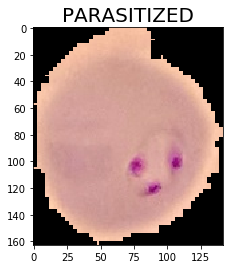

In [2]:
img = cv2.imread("./train_test_img/Parasitized/C33P1thinF_IMG_20150619_114756a_cell_179.png")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.title('PARASITIZED', size=20)
plt.imshow(img)

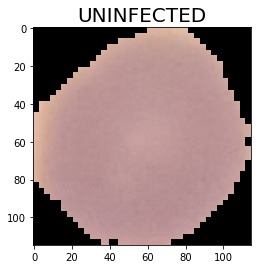

In [3]:
img = cv2.imread("./train_test_img/Uninfected/C1_thinF_IMG_20150604_104722_cell_9.png")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.title('UNINFECTED', size=20)
plt.imshow(img)

# Pre-processing Images

In [4]:
import random

In [5]:
img_size = 70

In [6]:
def image_preprocesser(path, label):
    temp_list = []
    for i in tqdm(os.listdir(path)):
        try:
            img = cv2.imread('{}/{}'.format(path,i))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = (img - np.min(img)) / (np.max(img) - np.min(img))
            img = cv2.resize(img, (img_size,img_size))
            label = np.array(label)
            temp_list.append((img,label))
        except:
            print('Error Image Format')
    return temp_list

In [7]:
list_parasitized = image_preprocesser('./train_test_img/Parasitized/',1)
list_uninfected = image_preprocesser('./train_test_img/Uninfected/',0)

  1%|▌                                                                             | 90/13781 [00:00<00:31, 431.38it/s]

Error Image Format


100%|███████████████████████████████████████████████████████████████████████████| 13781/13781 [00:27<00:00, 509.97it/s]

Error Image Format



100%|███████████████████████████████████████████████████████████████████████████| 13780/13780 [00:32<00:00, 418.36it/s]

Error Image Format


# Model Data Preparation

In [8]:
list_total = list_parasitized + list_uninfected
random.shuffle(list_total)

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
list_total[0][0].shape

(70, 70)

In [11]:
X = [i[0] for i in list_total]
X = np.array(X)
X = np.reshape(X, (-1,img_size,img_size,1))

y = [i[1] for i in list_total]
y = np.array(y)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=101)

# Making the Model

In [13]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [14]:
model_checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', save_weights_only=True,
                                            monitor='val_acc', mode='max', save_best_only=True,verbose=1)

model_earlystopping_callback = EarlyStopping(monitor='val_loss', patience=2)

model_plateau_callback = ReduceLROnPlateau(monitor='val_loss', patience=1)

callback_list = [model_checkpoint_callback, model_earlystopping_callback, model_plateau_callback]

In [15]:
model = Sequential()

model.add(Conv2D(64,(3,3), activation = 'relu', input_shape =(img_size,img_size,1)))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(64,(3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(64,(3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(64,(3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=['accuracy'])

model.load_weights('best_model.h5')

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 68, 68, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 34, 34, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 64)          36928     
__________

In [18]:
model.fit(x=X_train, y=y_train, callbacks=callback_list, batch_size=32, epochs=6, validation_split=0.15)

Train on 19910 samples, validate on 3514 samples
Epoch 1/6
19910/19910 [==============================] - 404s 20ms/step - loss: 0.5449 - acc: 0.6662 - val_loss: 0.2539 - val_acc: 0.8964

Epoch 00001: val_acc improved from -inf to 0.89641, saving model to best_model.h5
Epoch 2/6
19910/19910 [==============================] - 338s 17ms/step - loss: 0.2188 - acc: 0.9171 - val_loss: 0.2180 - val_acc: 0.9129

Epoch 00002: val_acc improved from 0.89641 to 0.91292, saving model to best_model.h5
Epoch 3/6
19910/19910 [==============================] - 205s 10ms/step - loss: 0.1907 - acc: 0.9265 - val_loss: 0.1895 - val_acc: 0.9306

Epoch 00003: val_acc improved from 0.91292 to 0.93056, saving model to best_model.h5
Epoch 4/6
19910/19910 [==============================] - 205s 10ms/step - loss: 0.1742 - acc: 0.9348 - val_loss: 0.1734 - val_acc: 0.9368

Epoch 00004: val_acc improved from 0.93056 to 0.93682, saving model to best_model.h5
Epoch 5/6
19910/19910 [==============================] - 2

# Results Exploration

In [19]:
df_model = pd.DataFrame(model.history.history)

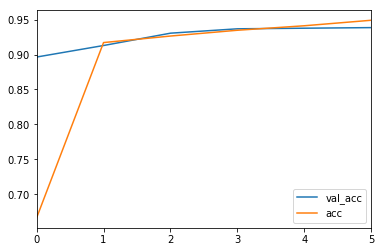

In [20]:
df_model[['val_acc','acc']].plot()

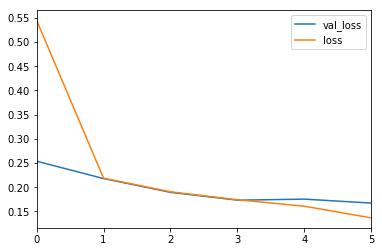

In [21]:
df_model[['val_loss','loss']].plot()

In [17]:
predictions = model.predict_classes(X_test)

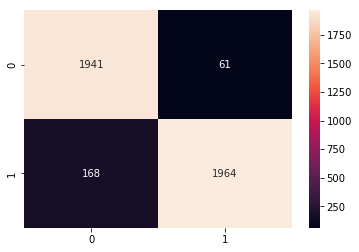

In [24]:
from sklearn.metrics import confusion_matrix, classification_report

cf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(cf_matrix, annot=True, fmt='g')

In [25]:
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.92      0.97      0.94      2002
          1       0.97      0.92      0.94      2132

avg / total       0.95      0.94      0.94      4134



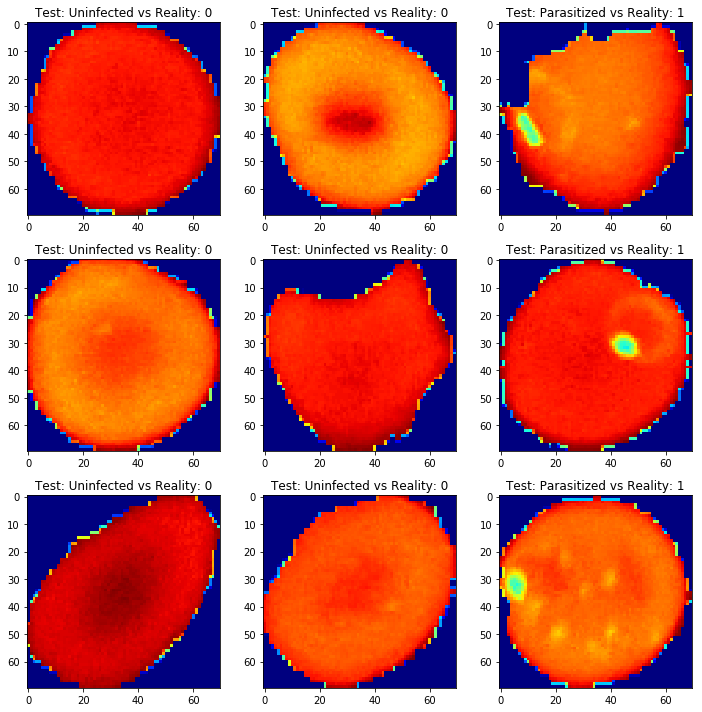

In [19]:
width=8
height=8
rows = 3
cols = 3
axes=[]
fig=plt.figure(figsize=(10,10))

for a in range(rows*cols):
    b = np.reshape(X_test[a], (img_size,img_size))
    axes.append(fig.add_subplot(rows, cols, a+1))
    if predictions[a][0] == 1:
        subplot_title=('Test: Parasitized vs Reality: {}'.format(y_test[a]))
    else:
        subplot_title=('Test: Uninfected vs Reality: {}'.format(y_test[a]))
    axes[-1].set_title(subplot_title)  
    plt.imshow(b, cmap='jet')
fig.tight_layout()    
plt.show()

# 1: Parasitized, 0: Uninfected